In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import re
import requests # get url data
from bs4 import BeautifulSoup # manipulate url data
import json
from pandas import DataFrame as df

In [2]:
df =pd.read_csv('data/owid-covid-data.csv')
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52873 entries, 0 to 52872
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         52571 non-null  object 
 1   continent                        52269 non-null  object 
 2   location                         52873 non-null  object 
 3   date                             52873 non-null  object 
 4   total_cases                      49259 non-null  float64
 5   new_cases                        51979 non-null  float64
 6   new_cases_smoothed               51185 non-null  float64
 7   total_deaths                     40323 non-null  float64
 8   new_deaths                       51979 non-null  float64
 9   new_deaths_smoothed              51185 non-null  float64
 10  total_cases_per_million          48993 non-null  float64
 11  new_cases_per_million            51915 non-null  float64
 12  new_cases_smoothed

<Axes: xlabel='date'>

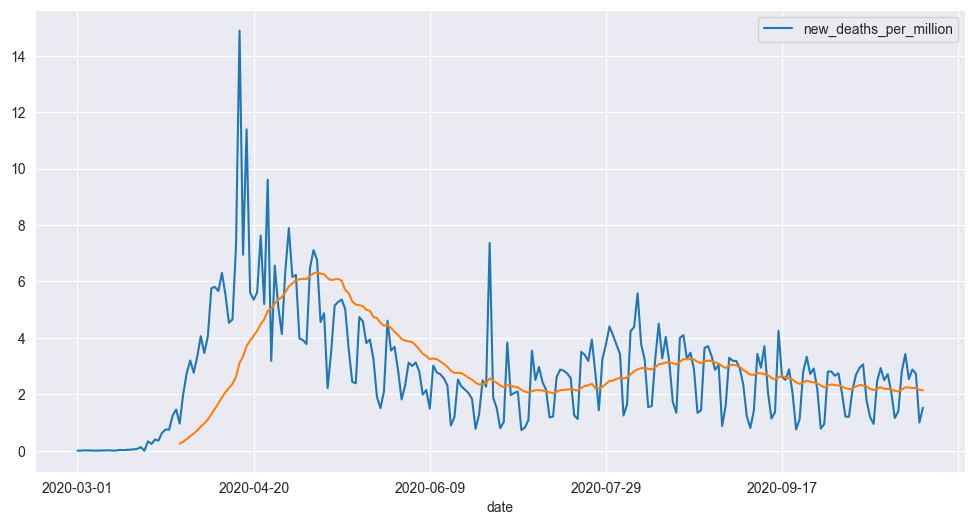

In [4]:
covid_country = df.location.unique()
indexer = df[df['location']=='United States'].index
covid_country = df.loc[indexer, 'date' : 'new_deaths_per_million']
covid_country = covid_country.dropna()
covid_country.set_index('date', inplace=True)
covid_country.drop(covid_country.columns.difference(['new_deaths_per_million']), axis=1, inplace=True)
covid_country.plot(figsize=(12,6))
covid_country.rolling(window=30).mean()['new_deaths_per_million'].plot()

In [5]:
#converting index dtype to datetime
covid_country.index = pd.to_datetime(covid_country.index)
covid_country.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2020-03-01 to 2020-10-27
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_deaths_per_million  241 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


In [6]:
#separating data for forecasting
train_df = covid_country.iloc[:192]
test_df = covid_country.iloc[191:]

#### Holt-Winters Model with training data

###### The Holt-Winters method : average, trend & seasonality

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train_df['new_deaths_per_million'],freq='D', trend='add', seasonal='add', seasonal_periods=14).fit()
prediction = model.forecast(50) # forecast for 50 days

<Axes: xlabel='date'>

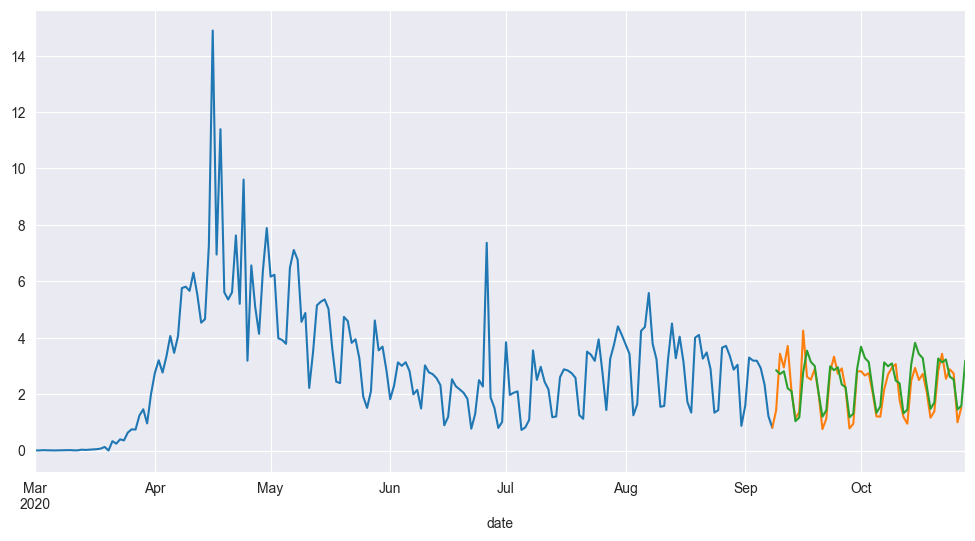

In [8]:
train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
prediction.plot()

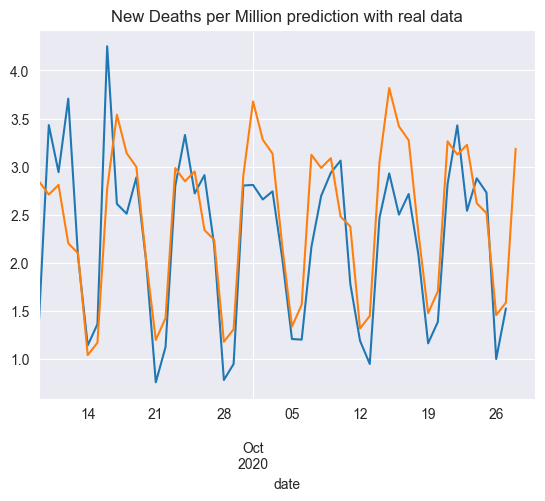

In [9]:
#looking on specific date
test_df['new_deaths_per_million'].plot()
prediction.plot(xlim=['2020-09-09','2020-10-30'])

plt.title('New Deaths per Million prediction with real data')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

print('mean abs error :',mean_absolute_error(test_df, prediction))
print('mean squared error :',mean_squared_error(test_df, prediction))
print('root mean squared error :',root_mean_squared_error(test_df, prediction))

mean abs error : 0.8145006132823069
mean squared error : 0.9725288155378398
root mean squared error : 0.9861687561152197


#### How errors work :

In [11]:
def mae(y_true, y_pred):
    y_true_np = y_true.to_numpy()
    y_pred_np = y_pred.to_numpy()
    return np.mean(np.abs(y_true_np - y_pred_np))
mae(test_df, prediction)

0.9622484617859139

In [12]:
def mse(y_true, y_pred):
    y_true_np = y_true.to_numpy()
    y_pred_np = y_pred.to_numpy()
    return ((y_true_np-y_pred_np)**2).mean()
mse(test_df, prediction)

1.4200220173467748

In [13]:
np.sqrt(mse(test_df, prediction))

1.1916467670189748

<Axes: xlabel='date'>

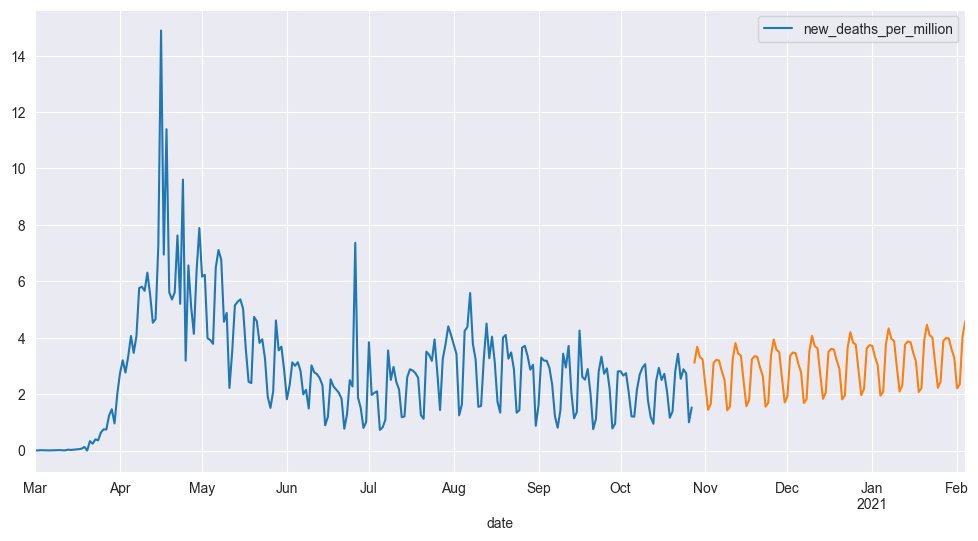

In [14]:
covid_model = ExponentialSmoothing(covid_country['new_deaths_per_million'],freq='D', trend='add', seasonal='add', seasonal_periods=14).fit()
covid_forecast = covid_model.forecast(100)
covid_country.plot(figsize=(12,6))
covid_forecast.plot()